In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision.datasets import Caltech256
from torchvision.transforms import v2
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch import Trainer
from lightning.pytorch import loggers as pl_loggers
import matplotlib.pyplot as plt

from library.taxonomy_constructors import SyntheticTaxonomy, CrossPredictionsTaxonomy
from library.models import ResNetModel
from library.datasets import (
    Caltech256DomainShiftedDataModule,
    CIFAR100DomainShiftedDataModule,
    CIFAR100Mapped,
)

# Load Caltech256 dataset information
caltech256_labels = Caltech256(root="datasets/caltech256", download=False).categories
caltech256_targets = pd.read_csv("data/caltech256.csv")

# Load CIFAR100 dataset information
cifar100_dataset = CIFAR100Mapped(root="datasets/cifar100", download=False)
cifar100_labels = cifar100_dataset.classes

# Reduce the precision of matrix multiplication to speed up training
torch.set_float32_matmul_precision("medium")

In [2]:
# Define domain shift transforms
domain_shift_A = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.GaussianNoise(mean=0.0, sigma=0.1),
    ]
)

domain_shift_B = v2.Compose(
    [
        v2.RandomRotation(degrees=[-30, 30], expand=False),
        v2.RandomPhotometricDistort(),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    ]
)

# Additional domain shift for 3-domain experiments
domain_shift_C = v2.Compose(
    [
        v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        v2.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
        v2.RandomPerspective(distortion_scale=0.3, p=0.5),
    ]
)

Visualizing domain shift effects...


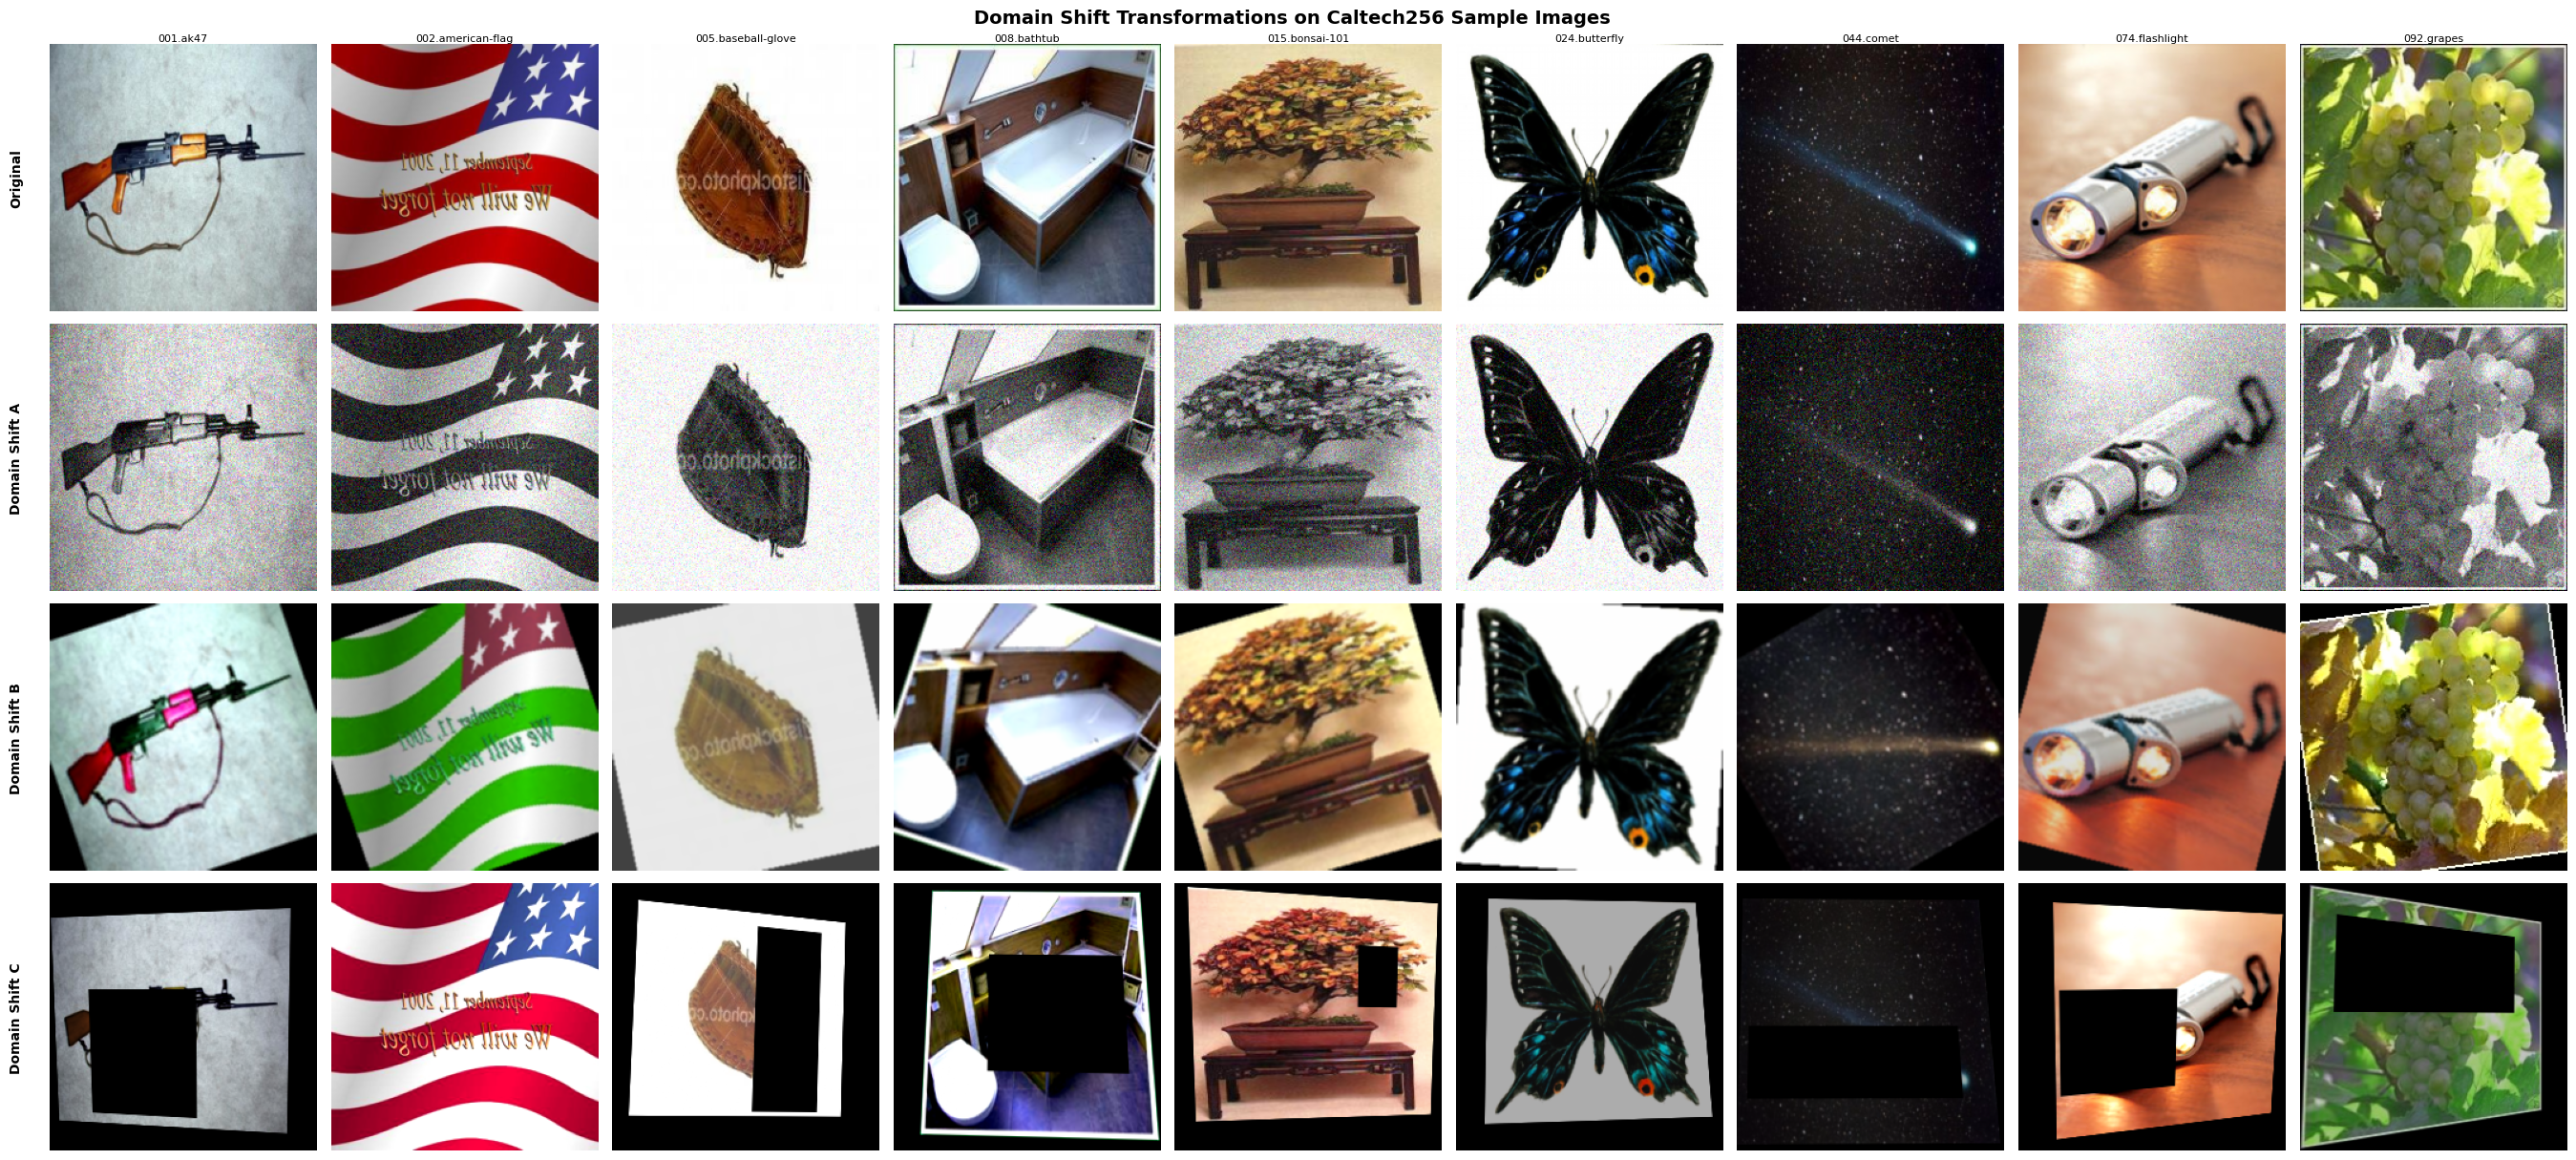

Domain shift visualization saved to figures/domain_shift_visualization.png


In [14]:
def visualize_domain_shifts(num_samples=9):
    """
    Visualize the effects of the three domain shift transforms on sample images.
    Shows original images and their transformed versions in a 3x3 grid.
    """
    # Load a few sample images from Caltech256 for visualization
    from torchvision.datasets import Caltech256
    from torchvision.transforms import v2 as transforms
    import matplotlib.pyplot as plt

    # Basic transform to convert PIL to tensor for visualization
    basic_transform = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Resize((224, 224)),
        ]
    )

    # Load dataset with basic transform
    dataset = Caltech256(
        root="datasets/caltech256", download=False, transform=basic_transform
    )

    # Get a few sample images (using fixed indices for reproducibility)
    sample_indices = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000][:num_samples]
    sample_images = []
    sample_labels = []

    for idx in sample_indices:
        if idx < len(dataset):
            img, label = dataset[idx]
            sample_images.append(img)
            sample_labels.append(dataset.categories[label])

    # Create figure with subplots
    fig, axes = plt.subplots(
        4, len(sample_images), figsize=(3 * len(sample_images), 12)
    )
    if len(sample_images) == 1:
        axes = axes.reshape(-1, 1)

    transforms_list = [
        ("Original", lambda x: x),
        ("Domain Shift A", domain_shift_A),
        ("Domain Shift B", domain_shift_B),
        ("Domain Shift C", domain_shift_C),
    ]

    for row, (transform_name, transform_func) in enumerate(transforms_list):
        for col, (img, label) in enumerate(zip(sample_images, sample_labels)):
            # Apply transform
            if transform_name == "Original":
                transformed_img = img
            else:
                transformed_img = transform_func(img)

            # Convert tensor to numpy for plotting
            img_np = transformed_img.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)  # Ensure values are in [0,1] range

            # Plot
            axes[row, col].imshow(img_np)
            axes[row, col].axis("off")

            # Add title only for first row
            if row == 0:
                axes[row, col].set_title(f"{label}", fontsize=8, pad=2)

        # Add row label
        axes[row, 0].text(
            -0.1,
            0.5,
            transform_name,
            rotation=90,
            verticalalignment="center",
            horizontalalignment="right",
            transform=axes[row, 0].transAxes,
            fontsize=10,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.suptitle(
        "Domain Shift Transformations on Caltech256 Sample Images",
        fontsize=14,
        fontweight="bold",
        y=1.01,
    )
    plt.savefig(
        "../thesis/figures/domain_shift_visualization.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print(f"Domain shift visualization saved to figures/domain_shift_visualization.png")


# Call the visualization function
print("Visualizing domain shift effects...")
visualize_domain_shifts(num_samples=9)

In [11]:
# Configuration
TRAIN = True  # Set to True to train models from scratch
PREDICT = True  # Set to True to generate predictions from scratch


def train_caltech256_domain_shifted_model(
    domain_mapping, domain_shift_transform, domain_name, logger_name, model_name
):
    """Train a ResNet model for a specific domain with domain shift using Caltech256"""
    tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs", name=logger_name)
    dataset = Caltech256DomainShiftedDataModule(
        mapping=domain_mapping, domain_shift_transform=domain_shift_transform
    )

    trainer = Trainer(
        max_epochs=50,
        logger=tb_logger if TRAIN else False,
        callbacks=[
            ModelCheckpoint(
                dirpath="checkpoints",
                monitor="val_loss",
                mode="min",
                save_top_k=1,
                filename=model_name,
                enable_version_counter=False,
            )
        ],
    )

    if TRAIN:
        model = ResNetModel(
            num_classes=len(set(domain_mapping.values())),
            architecture="resnet50",
            optim="sgd",
            optim_kwargs={
                "lr": 0.01,
                "momentum": 0.9,
                "weight_decay": 5e-4,
            },
        )
        trainer.fit(model, datamodule=dataset)
        results = trainer.test(datamodule=dataset, ckpt_path="best")
    else:
        try:
            model = ResNetModel.load_from_checkpoint(f"checkpoints/{model_name}.ckpt")
            results = trainer.test(model, datamodule=dataset)
        except FileNotFoundError:
            print(
                f"Checkpoint {model_name}.ckpt not found. Please set TRAIN=True to train the model."
            )
            return None

    print(f"{domain_name} Results: {results}")
    return results


def train_cifar100_domain_shifted_model(
    domain_mapping, domain_shift_transform, domain_name, logger_name, model_name
):
    """Train a ResNet model for a specific domain with domain shift using CIFAR100"""
    tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs", name=logger_name)
    dataset = CIFAR100DomainShiftedDataModule(
        mapping=domain_mapping,
        domain_shift_transform=domain_shift_transform,
        batch_size=256,
    )

    callbacks = [
        ModelCheckpoint(
            dirpath="checkpoints",
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            filename=model_name,
            enable_version_counter=False,
        ),
        LearningRateMonitor(logging_interval="epoch"),
    ]

    trainer = Trainer(
        max_epochs=100,
        logger=tb_logger if TRAIN else False,
        callbacks=callbacks,
        gradient_clip_val=1.0,
        gradient_clip_algorithm="norm",
    )

    if TRAIN:
        model = ResNetModel(
            num_classes=len(set(domain_mapping.values())),
            architecture="resnet50",
            optim="adamw",
            optim_kwargs={
                "lr": 0.001,
                "weight_decay": 1e-3,
            },
            lr_scheduler="multistep",
            lr_scheduler_kwargs={
                "milestones": [30, 60, 80],
                "gamma": 0.1,
            },
        )
        trainer.fit(model, datamodule=dataset)
        results = trainer.test(datamodule=dataset, ckpt_path="best")
    else:
        try:
            model = ResNetModel.load_from_checkpoint(f"checkpoints/{model_name}.ckpt")
            results = trainer.test(model, datamodule=dataset)
        except FileNotFoundError:
            print(
                f"Checkpoint {model_name}.ckpt not found. Please set TRAIN=True to train the model."
            )
            return None

    print(f"{domain_name} Results: {results}")
    return results

In [4]:
# Create synthetic taxonomy with 2 domains
synthetic_taxonomy = SyntheticTaxonomy.create_synthetic_taxonomy(
    num_atomic_concepts=257,
    num_domains=2,
    domain_class_count_mean=180,
    domain_class_count_variance=10,
    concept_cluster_size_mean=3,
    concept_cluster_size_variance=1,
    no_prediction_class=True,
    atomic_concept_labels=caltech256_labels,
    relationship_type="true",
)

# Extract domain mappings
domain_A_mapping = synthetic_taxonomy.domains[0].to_mapping()
domain_B_mapping = synthetic_taxonomy.domains[1].to_mapping()

print(f"Domain A classes: {len(set(domain_A_mapping.values()))}")
print(f"Domain B classes: {len(set(domain_B_mapping.values()))}")

Domain A classes: 62
Domain B classes: 59


In [5]:
# Train Domain A model
print("Training/Testing Domain A Model:")
domain_A_results = train_caltech256_domain_shifted_model(
    domain_A_mapping,
    domain_shift_A,
    "Domain A",
    "caltech256_synthetic_domain_shifted_A",
    "resnet50-caltech256-synthetic-domain-shifted-A-min-val-loss",
)

# Train Domain B model
print("Training/Testing Domain B Model:")
domain_B_results = train_caltech256_domain_shifted_model(
    domain_B_mapping,
    domain_shift_B,
    "Domain B",
    "caltech256_synthetic_domain_shifted_B",
    "resnet50-caltech256-synthetic-domain-shifted-B-min-val-loss",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training/Testing Domain A Model:


/home/bjoern/miniconda3/envs/master-thesis/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/bjoern/dev/master-thesis/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 26.3 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
26.3 M    Trainable params
0         Non-trainable params
26.3 M    Total params
105.213   Total estimated model params size (MB)
162       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/bjoern/miniconda3/envs/master-thesis/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/bjoern/miniconda3/envs/master-thesis/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:  70%|██████▉   | 192/276 [02:05<00:54,  1.53it/s, v_num=0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# Generate cross-domain predictions
if PREDICT:
    # Load datasets with domain shifts
    dataset_domain_A = Caltech256DomainShiftedDataModule(
        mapping=domain_A_mapping, domain_shift_transform=domain_shift_A
    )
    dataset_domain_B = Caltech256DomainShiftedDataModule(
        mapping=domain_B_mapping, domain_shift_transform=domain_shift_B
    )

    # Load trained models
    model_domain_A = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-domain-shifted-A-min-val-loss.ckpt"
    )
    model_domain_A.eval()

    model_domain_B = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-domain-shifted-B-min-val-loss.ckpt"
    )
    model_domain_B.eval()

    trainer = Trainer(logger=False, enable_checkpointing=False)

    # Generate cross-domain predictions
    print("Generating cross-domain predictions...")
    model_A_on_domain_B = trainer.predict(model_domain_A, datamodule=dataset_domain_B)
    model_B_on_domain_A = trainer.predict(model_domain_B, datamodule=dataset_domain_A)

    # Convert predictions to class indices
    predictions_A_on_B = torch.cat(model_A_on_domain_B).argmax(dim=1)  # type: ignore
    predictions_B_on_A = torch.cat(model_B_on_domain_A).argmax(dim=1)  # type: ignore

    # Get ground truth targets
    domain_A_targets = torch.cat(
        [label for _, label in dataset_domain_A.predict_dataloader()]
    )
    domain_B_targets = torch.cat(
        [label for _, label in dataset_domain_B.predict_dataloader()]
    )

    # Save predictions
    pd.DataFrame(
        {
            "domain_A": domain_A_targets,
            "predictions_B_on_A": predictions_B_on_A,
        }
    ).to_csv("data/caltech256_2domain_domain_shifted_A_predictions.csv", index=False)

    pd.DataFrame(
        {
            "domain_B": domain_B_targets,
            "predictions_A_on_B": predictions_A_on_B,
        }
    ).to_csv("data/caltech256_2domain_domain_shifted_B_predictions.csv", index=False)

    print("Predictions saved to CSV files.")

# Load prediction results
df_A = pd.read_csv("data/caltech256_2domain_domain_shifted_A_predictions.csv")
df_B = pd.read_csv("data/caltech256_2domain_domain_shifted_B_predictions.csv")

print(f"Domain A predictions shape: {df_A.shape}")
print(f"Domain B predictions shape: {df_B.shape}")

In [ ]:
# Construct taxonomy from cross-domain predictions
taxonomy = CrossPredictionsTaxonomy.from_cross_domain_predictions(
    cross_domain_predictions=[
        (0, 1, np.array(df_B["predictions_A_on_B"], dtype=np.intp)),
        (1, 0, np.array(df_A["predictions_B_on_A"], dtype=np.intp)),
    ],
    domain_targets=[
        (0, np.array(df_A["domain_A"], dtype=np.intp)),
        (1, np.array(df_B["domain_B"], dtype=np.intp)),
    ],
    domain_labels=synthetic_taxonomy.domain_labels,
    relationship_type="hypothesis",
)

print("Taxonomy constructed from cross-domain predictions.")

# Generate and save taxonomy visualizations
print("Generating taxonomy visualizations...")

taxonomy.visualize_graph(
    "2-Domain Caltech256 Domain Shifted Model Taxonomy"
).save_graph("output/caltech256_2domain_domain_shifted_synthetic_model_taxonomy.html")

synthetic_taxonomy.visualize_graph(
    "2-Domain Caltech256 Domain Shifted Ground Truth Taxonomy",
    height=2000,
    width=2000,
).save_graph("output/caltech256_2domain_domain_shifted_synthetic_taxonomy.html")

print("Taxonomy visualizations saved to output/ directory.")

# Evaluate taxonomy against ground truth
edr = taxonomy.edge_difference_ratio(synthetic_taxonomy)
precision, recall, f1 = taxonomy.precision_recall_f1(synthetic_taxonomy)

print("2-Domain Domain Shifted Synthetic Taxonomy Evaluation:")
print(f"Edge Difference Ratio: {edr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Build universal taxonomies
print("Building universal taxonomies...")

taxonomy.build_universal_taxonomy()
taxonomy.visualize_graph(
    "2-Domain Caltech256 Domain Shifted Model Universal Taxonomy"
).save_graph(
    "output/caltech256_2domain_domain_shifted_synthetic_model_universal_taxonomy.html"
)

synthetic_taxonomy.build_universal_taxonomy()
synthetic_taxonomy.visualize_graph(
    "2-Domain Caltech256 Domain Shifted Ground Truth Universal Taxonomy"
).save_graph(
    "output/caltech256_2domain_domain_shifted_synthetic_universal_taxonomy.html"
)

print("Universal taxonomy visualizations saved to output/ directory.")

In [ ]:
# Create synthetic taxonomy with 2 domains (variant parameters)
synthetic_taxonomy_variant = SyntheticTaxonomy.create_synthetic_taxonomy(
    num_atomic_concepts=257,
    num_domains=2,
    domain_class_count_mean=200,
    domain_class_count_variance=10,
    concept_cluster_size_mean=2,
    concept_cluster_size_variance=1,
    no_prediction_class=True,
    atomic_concept_labels=caltech256_labels,
    relationship_type="true",
)

# Extract domain mappings
domain_A_mapping_variant = synthetic_taxonomy_variant.domains[0].to_mapping()
domain_B_mapping_variant = synthetic_taxonomy_variant.domains[1].to_mapping()

print(f"Variant Domain A classes: {len(set(domain_A_mapping_variant.values()))}")
print(f"Variant Domain B classes: {len(set(domain_B_mapping_variant.values()))}")

In [ ]:
# Train Domain A model (variant)
print("Training/Testing Variant Domain A Model:")
domain_A_results_variant = train_caltech256_domain_shifted_model(
    domain_A_mapping_variant,
    domain_shift_A,
    "Variant Domain A",
    "caltech256_synthetic_variant_domain_shifted_A",
    "resnet50-caltech256-synthetic-variant-domain-shifted-A-min-val-loss",
)

# Train Domain B model (variant)
print("Training/Testing Variant Domain B Model:")
domain_B_results_variant = train_caltech256_domain_shifted_model(
    domain_B_mapping_variant,
    domain_shift_B,
    "Variant Domain B",
    "caltech256_synthetic_variant_domain_shifted_B",
    "resnet50-caltech256-synthetic-variant-domain-shifted-B-min-val-loss",
)

### 2.3 Generate Cross-Domain Predictions and Evaluate

# Generate cross-domain predictions for variant
if PREDICT:
    # Load datasets with domain shifts
    dataset_domain_A_variant = Caltech256DomainShiftedDataModule(
        mapping=domain_A_mapping_variant, domain_shift_transform=domain_shift_A
    )
    dataset_domain_B_variant = Caltech256DomainShiftedDataModule(
        mapping=domain_B_mapping_variant, domain_shift_transform=domain_shift_B
    )

    # Load trained models
    model_domain_A_variant = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-variant-domain-shifted-A-min-val-loss.ckpt"
    )
    model_domain_A_variant.eval()

    model_domain_B_variant = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-variant-domain-shifted-B-min-val-loss.ckpt"
    )
    model_domain_B_variant.eval()

    trainer = Trainer(logger=False, enable_checkpointing=False)

    # Generate cross-domain predictions
    print("Generating variant cross-domain predictions...")
    model_A_on_domain_B_variant = trainer.predict(
        model_domain_A_variant, datamodule=dataset_domain_B_variant
    )
    model_B_on_domain_A_variant = trainer.predict(
        model_domain_B_variant, datamodule=dataset_domain_A_variant
    )

    # Convert predictions to class indices
    predictions_A_on_B_variant = torch.cat(model_A_on_domain_B_variant).argmax(dim=1)  # type: ignore
    predictions_B_on_A_variant = torch.cat(model_B_on_domain_A_variant).argmax(dim=1)  # type: ignore

    # Get ground truth targets
    domain_A_targets_variant = torch.cat(
        [label for _, label in dataset_domain_A_variant.predict_dataloader()]
    )
    domain_B_targets_variant = torch.cat(
        [label for _, label in dataset_domain_B_variant.predict_dataloader()]
    )

    # Save predictions
    pd.DataFrame(
        {
            "domain_A": domain_A_targets_variant,
            "predictions_B_on_A": predictions_B_on_A_variant,
        }
    ).to_csv(
        "data/caltech256_2domain_variant_domain_shifted_A_predictions.csv", index=False
    )

    pd.DataFrame(
        {
            "domain_B": domain_B_targets_variant,
            "predictions_A_on_B": predictions_A_on_B_variant,
        }
    ).to_csv(
        "data/caltech256_2domain_variant_domain_shifted_B_predictions.csv", index=False
    )

    print("Variant predictions saved to CSV files.")

# Load prediction results
df_A_variant = pd.read_csv(
    "data/caltech256_2domain_variant_domain_shifted_A_predictions.csv"
)
df_B_variant = pd.read_csv(
    "data/caltech256_2domain_variant_domain_shifted_B_predictions.csv"
)

# Construct and evaluate taxonomy for variant
taxonomy_variant = CrossPredictionsTaxonomy.from_cross_domain_predictions(
    cross_domain_predictions=[
        (0, 1, np.array(df_B_variant["predictions_A_on_B"], dtype=np.intp)),
        (1, 0, np.array(df_A_variant["predictions_B_on_A"], dtype=np.intp)),
    ],
    domain_targets=[
        (0, np.array(df_A_variant["domain_A"], dtype=np.intp)),
        (1, np.array(df_B_variant["domain_B"], dtype=np.intp)),
    ],
    domain_labels=synthetic_taxonomy_variant.domain_labels,
    relationship_type="hypothesis",
)

print("Variant taxonomy constructed from cross-domain predictions.")

# Evaluate variant taxonomy
edr_variant = taxonomy_variant.edge_difference_ratio(synthetic_taxonomy_variant)
precision_variant, recall_variant, f1_variant = taxonomy_variant.precision_recall_f1(
    synthetic_taxonomy_variant
)

print("2-Domain Variant Domain Shifted Synthetic Taxonomy Evaluation:")
print(f"Edge Difference Ratio: {edr_variant:.4f}")
print(f"Precision: {precision_variant:.4f}")
print(f"Recall: {recall_variant:.4f}")
print(f"F1 Score: {f1_variant:.4f}")

In [ ]:
# Create synthetic taxonomy with 3 domains
synthetic_taxonomy_3domain = SyntheticTaxonomy.create_synthetic_taxonomy(
    num_atomic_concepts=257,
    num_domains=3,
    domain_class_count_mean=180,
    domain_class_count_variance=10,
    concept_cluster_size_mean=5,
    concept_cluster_size_variance=1,
    no_prediction_class=True,
    atomic_concept_labels=caltech256_labels,
    relationship_type="true",
)

# Extract domain mappings
domain_A_mapping_3d = synthetic_taxonomy_3domain.domains[0].to_mapping()
domain_B_mapping_3d = synthetic_taxonomy_3domain.domains[1].to_mapping()
domain_C_mapping_3d = synthetic_taxonomy_3domain.domains[2].to_mapping()

print(f"3-Domain A classes: {len(set(domain_A_mapping_3d.values()))}")
print(f"3-Domain B classes: {len(set(domain_B_mapping_3d.values()))}")
print(f"3-Domain C classes: {len(set(domain_C_mapping_3d.values()))}")

### 3.2 Train Domain-Specific Models

# Train all three domain models with different domain shifts
print("Training/Testing 3-Domain A Model:")
domain_A_results_3d = train_caltech256_domain_shifted_model(
    domain_A_mapping_3d,
    domain_shift_A,
    "3-Domain A",
    "caltech256_synthetic_3domain_shifted_A",
    "resnet50-caltech256-synthetic-3domain-shifted-A-min-val-loss",
)

print("Training/Testing 3-Domain B Model:")
domain_B_results_3d = train_caltech256_domain_shifted_model(
    domain_B_mapping_3d,
    domain_shift_B,
    "3-Domain B",
    "caltech256_synthetic_3domain_shifted_B",
    "resnet50-caltech256-synthetic-3domain-shifted-B-min-val-loss",
)

print("Training/Testing 3-Domain C Model:")
domain_C_results_3d = train_caltech256_domain_shifted_model(
    domain_C_mapping_3d,
    domain_shift_C,
    "3-Domain C",
    "caltech256_synthetic_3domain_shifted_C",
    "resnet50-caltech256-synthetic-3domain-shifted-C-min-val-loss",
)

### 3.3 Generate Cross-Domain Predictions (6 pairs)

# Generate cross-domain predictions for all 6 pairs in 3-domain setup
if PREDICT:
    # Load datasets for all three domains with their respective shifts
    dataset_domain_A_3d = Caltech256DomainShiftedDataModule(
        mapping=domain_A_mapping_3d, domain_shift_transform=domain_shift_A
    )
    dataset_domain_B_3d = Caltech256DomainShiftedDataModule(
        mapping=domain_B_mapping_3d, domain_shift_transform=domain_shift_B
    )
    dataset_domain_C_3d = Caltech256DomainShiftedDataModule(
        mapping=domain_C_mapping_3d, domain_shift_transform=domain_shift_C
    )

    # Load trained models
    model_domain_A_3d = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-3domain-shifted-A-min-val-loss.ckpt"
    )
    model_domain_A_3d.eval()

    model_domain_B_3d = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-3domain-shifted-B-min-val-loss.ckpt"
    )
    model_domain_B_3d.eval()

    model_domain_C_3d = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-3domain-shifted-C-min-val-loss.ckpt"
    )
    model_domain_C_3d.eval()

    trainer = Trainer(logger=False, enable_checkpointing=False)

    print("Generating 3-domain cross-domain predictions...")

    # Generate all 6 cross-domain predictions
    model_A_on_domain_B_3d = trainer.predict(
        model_domain_A_3d, datamodule=dataset_domain_B_3d
    )
    model_A_on_domain_C_3d = trainer.predict(
        model_domain_A_3d, datamodule=dataset_domain_C_3d
    )
    model_B_on_domain_A_3d = trainer.predict(
        model_domain_B_3d, datamodule=dataset_domain_A_3d
    )
    model_B_on_domain_C_3d = trainer.predict(
        model_domain_B_3d, datamodule=dataset_domain_C_3d
    )
    model_C_on_domain_A_3d = trainer.predict(
        model_domain_C_3d, datamodule=dataset_domain_A_3d
    )
    model_C_on_domain_B_3d = trainer.predict(
        model_domain_C_3d, datamodule=dataset_domain_B_3d
    )

    # Convert predictions to class indices
    predictions_A_on_B_3d = torch.cat(model_A_on_domain_B_3d).argmax(dim=1)  # type: ignore
    predictions_A_on_C_3d = torch.cat(model_A_on_domain_C_3d).argmax(dim=1)  # type: ignore
    predictions_B_on_A_3d = torch.cat(model_B_on_domain_A_3d).argmax(dim=1)  # type: ignore
    predictions_B_on_C_3d = torch.cat(model_B_on_domain_C_3d).argmax(dim=1)  # type: ignore
    predictions_C_on_A_3d = torch.cat(model_C_on_domain_A_3d).argmax(dim=1)  # type: ignore
    predictions_C_on_B_3d = torch.cat(model_C_on_domain_B_3d).argmax(dim=1)  # type: ignore

    # Get ground truth targets
    domain_A_targets_3d = torch.cat(
        [label for _, label in dataset_domain_A_3d.predict_dataloader()]
    )
    domain_B_targets_3d = torch.cat(
        [label for _, label in dataset_domain_B_3d.predict_dataloader()]
    )
    domain_C_targets_3d = torch.cat(
        [label for _, label in dataset_domain_C_3d.predict_dataloader()]
    )

    # Save all prediction results
    pd.DataFrame(
        {
            "domain_A": domain_A_targets_3d,
            "predictions_B_on_A": predictions_B_on_A_3d,
            "predictions_C_on_A": predictions_C_on_A_3d,
        }
    ).to_csv("data/caltech256_3domain_domain_shifted_A_predictions.csv", index=False)

    pd.DataFrame(
        {
            "domain_B": domain_B_targets_3d,
            "predictions_A_on_B": predictions_A_on_B_3d,
            "predictions_C_on_B": predictions_C_on_B_3d,
        }
    ).to_csv("data/caltech256_3domain_domain_shifted_B_predictions.csv", index=False)

    pd.DataFrame(
        {
            "domain_C": domain_C_targets_3d,
            "predictions_A_on_C": predictions_A_on_C_3d,
            "predictions_B_on_C": predictions_B_on_C_3d,
        }
    ).to_csv("data/caltech256_3domain_domain_shifted_C_predictions.csv", index=False)

    print("All 3-domain predictions saved to CSV files.")

# Load the prediction results
df_A_3domain = pd.read_csv("data/caltech256_3domain_domain_shifted_A_predictions.csv")
df_B_3domain = pd.read_csv("data/caltech256_3domain_domain_shifted_B_predictions.csv")
df_C_3domain = pd.read_csv("data/caltech256_3domain_domain_shifted_C_predictions.csv")

### 3.4 Construct and Evaluate Taxonomy

# Construct taxonomy from all cross-domain predictions (3 domains = 6 prediction pairs)
taxonomy_3domain = CrossPredictionsTaxonomy.from_cross_domain_predictions(
    cross_domain_predictions=[
        # Domain A → Domain B
        (0, 1, np.array(df_B_3domain["predictions_A_on_B"], dtype=np.intp)),
        # Domain A → Domain C
        (0, 2, np.array(df_C_3domain["predictions_A_on_C"], dtype=np.intp)),
        # Domain B → Domain A
        (1, 0, np.array(df_A_3domain["predictions_B_on_A"], dtype=np.intp)),
        # Domain B → Domain C
        (1, 2, np.array(df_C_3domain["predictions_B_on_C"], dtype=np.intp)),
        # Domain C → Domain A
        (2, 0, np.array(df_A_3domain["predictions_C_on_A"], dtype=np.intp)),
        # Domain C → Domain B
        (2, 1, np.array(df_B_3domain["predictions_C_on_B"], dtype=np.intp)),
    ],
    domain_targets=[
        (0, np.array(df_A_3domain["domain_A"], dtype=np.intp)),
        (1, np.array(df_B_3domain["domain_B"], dtype=np.intp)),
        (2, np.array(df_C_3domain["domain_C"], dtype=np.intp)),
    ],
    domain_labels=synthetic_taxonomy_3domain.domain_labels,
    relationship_type="hypothesis",
)

print("3-domain domain shifted taxonomy constructed from cross-domain predictions.")

# Evaluate the 3-domain taxonomy
edr_3domain = taxonomy_3domain.edge_difference_ratio(synthetic_taxonomy_3domain)
precision_3domain, recall_3domain, f1_3domain = taxonomy_3domain.precision_recall_f1(
    synthetic_taxonomy_3domain
)

print("3-Domain Domain Shifted Synthetic Taxonomy Evaluation:")
print(f"Edge Difference Ratio: {edr_3domain:.4f}")
print(f"Precision: {precision_3domain:.4f}")
print(f"Recall: {recall_3domain:.4f}")
print(f"F1 Score: {f1_3domain:.4f}")

In [ ]:
# Create synthetic taxonomy with 2 domains for CIFAR100
synthetic_taxonomy_cifar = SyntheticTaxonomy.create_synthetic_taxonomy(
    num_atomic_concepts=len(cifar100_labels),
    num_domains=2,
    domain_class_count_mean=50,
    domain_class_count_variance=5,
    concept_cluster_size_mean=3,
    concept_cluster_size_variance=1,
    no_prediction_class=True,
    atomic_concept_labels=cifar100_labels,
    relationship_type="true",
)

# Extract domain mappings
domain_A_mapping_cifar = synthetic_taxonomy_cifar.domains[0].to_mapping()
domain_B_mapping_cifar = synthetic_taxonomy_cifar.domains[1].to_mapping()

print(f"CIFAR100 Domain A classes: {len(set(domain_A_mapping_cifar.values()))}")
print(f"CIFAR100 Domain B classes: {len(set(domain_B_mapping_cifar.values()))}")
print(f"CIFAR100 Domain A original classes: {len(domain_A_mapping_cifar)}")
print(f"CIFAR100 Domain B original classes: {len(domain_B_mapping_cifar)}")

### 4.2 Train Domain-Specific Models with Enhanced Configuration

print("Training/Testing CIFAR100 Domain A Model:")
domain_A_results_cifar = train_cifar100_domain_shifted_model(
    domain_A_mapping_cifar,
    domain_shift_A,
    "CIFAR100 Domain A",
    "cifar100_synthetic_domain_shifted_A",
    "resnet50-cifar100-synthetic-domain-shifted-A-min-val-loss",
)

print("Training/Testing CIFAR100 Domain B Model:")
domain_B_results_cifar = train_cifar100_domain_shifted_model(
    domain_B_mapping_cifar,
    domain_shift_B,
    "CIFAR100 Domain B",
    "cifar100_synthetic_domain_shifted_B",
    "resnet50-cifar100-synthetic-domain-shifted-B-min-val-loss",
)

### 4.3 Generate Cross-Domain Predictions and Evaluate

# Generate cross-domain predictions for CIFAR100
if PREDICT:
    # Load datasets with domain shifts
    dataset_domain_A_cifar = CIFAR100DomainShiftedDataModule(
        mapping=domain_A_mapping_cifar,
        domain_shift_transform=domain_shift_A,
        batch_size=128,
    )
    dataset_domain_B_cifar = CIFAR100DomainShiftedDataModule(
        mapping=domain_B_mapping_cifar,
        domain_shift_transform=domain_shift_B,
        batch_size=128,
    )

    # Load trained models
    model_domain_A_cifar = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-cifar100-synthetic-domain-shifted-A-min-val-loss.ckpt"
    )
    model_domain_A_cifar.eval()

    model_domain_B_cifar = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-cifar100-synthetic-domain-shifted-B-min-val-loss.ckpt"
    )
    model_domain_B_cifar.eval()

    trainer = Trainer(logger=False, enable_checkpointing=False)

    # Generate cross-domain predictions
    print("Generating CIFAR100 cross-domain predictions...")
    model_A_on_domain_B_cifar = trainer.predict(
        model_domain_A_cifar, datamodule=dataset_domain_B_cifar
    )
    model_B_on_domain_A_cifar = trainer.predict(
        model_domain_B_cifar, datamodule=dataset_domain_A_cifar
    )

    # Convert predictions to class indices
    predictions_A_on_B_cifar = torch.cat(model_A_on_domain_B_cifar).argmax(dim=1)  # type: ignore
    predictions_B_on_A_cifar = torch.cat(model_B_on_domain_A_cifar).argmax(dim=1)  # type: ignore

    # Get ground truth targets
    domain_A_targets_cifar = torch.cat(
        [label for _, label in dataset_domain_A_cifar.predict_dataloader()]
    )
    domain_B_targets_cifar = torch.cat(
        [label for _, label in dataset_domain_B_cifar.predict_dataloader()]
    )

    # Save predictions
    pd.DataFrame(
        {
            "domain_A": domain_A_targets_cifar,
            "predictions_B_on_A": predictions_B_on_A_cifar,
        }
    ).to_csv("data/cifar100_2domain_domain_shifted_A_predictions.csv", index=False)

    pd.DataFrame(
        {
            "domain_B": domain_B_targets_cifar,
            "predictions_A_on_B": predictions_A_on_B_cifar,
        }
    ).to_csv("data/cifar100_2domain_domain_shifted_B_predictions.csv", index=False)

    print("CIFAR100 predictions saved to CSV files.")

# Load prediction results
df_A_cifar = pd.read_csv("data/cifar100_2domain_domain_shifted_A_predictions.csv")
df_B_cifar = pd.read_csv("data/cifar100_2domain_domain_shifted_B_predictions.csv")

# Construct taxonomy from cross-domain predictions
taxonomy_cifar = CrossPredictionsTaxonomy.from_cross_domain_predictions(
    cross_domain_predictions=[
        (0, 1, np.array(df_B_cifar["predictions_A_on_B"], dtype=np.intp)),
        (1, 0, np.array(df_A_cifar["predictions_B_on_A"], dtype=np.intp)),
    ],
    domain_targets=[
        (0, np.array(df_A_cifar["domain_A"], dtype=np.intp)),
        (1, np.array(df_B_cifar["domain_B"], dtype=np.intp)),
    ],
    domain_labels=synthetic_taxonomy_cifar.domain_labels,
    relationship_type="density_threshold",
    threshold=0.6,
)

print("CIFAR100 domain shifted taxonomy constructed from cross-domain predictions.")

# Evaluate taxonomy against ground truth
edr_cifar = taxonomy_cifar.edge_difference_ratio(synthetic_taxonomy_cifar)
precision_cifar, recall_cifar, f1_cifar = taxonomy_cifar.precision_recall_f1(
    synthetic_taxonomy_cifar
)

print("2-Domain CIFAR100 Domain Shifted Taxonomy Evaluation:")
print(f"Edge Difference Ratio: {edr_cifar:.4f}")
print(f"Precision: {precision_cifar:.4f}")
print(f"Recall: {recall_cifar:.4f}")
print(f"F1 Score: {f1_cifar:.4f}")

# Generate and save taxonomy visualizations
print("Generating CIFAR100 taxonomy visualizations...")

taxonomy_cifar.visualize_graph(
    "2-Domain CIFAR100 Domain Shifted Model Taxonomy"
).save_graph("output/cifar100_2domain_domain_shifted_synthetic_model_taxonomy.html")

synthetic_taxonomy_cifar.visualize_graph(
    "2-Domain CIFAR100 Domain Shifted Ground Truth Taxonomy",
    height=2000,
    width=2000,
).save_graph("output/cifar100_2domain_domain_shifted_synthetic_taxonomy.html")

print("CIFAR100 taxonomy visualizations saved to output/ directory.")